# Bus Stops in Buenos Aires (CABA) - EDA


## 1. Introduction

In this notebook I explore the distribution of bus stops in Buenos Aires (CABA). I use the cleaned layers from the data cleaning step (stops, streets, comunas, barrios) to get a basic overview, compare areas, and spot patterns on maps.

The goal here is not to build a model, but to understand where stops are concentrated, how coverage looks across the city, and which streets/lines stand out.

### 1.2 Questions/Objectives:

- How many stops are there in total, and how are they distributed across communes and neighborhoods?
- Which areas concentrate the highest number of stops?
- Which comunas and barrios have the highest stop density (stops per km²)?
- Which streets have the most stops? Do they look like main corridors?
- Which bus lines have the most stops, and which comunas/barrios have the most distinct lines?
- Where are the highest-connectivity stop areas in the city (based on distinct bus lines)?

## 1. Introduction
### 1.1 Context
### 1.2 Questions

## 2. Setup
### 2.1 Imports
### 2.2 Loading processed data
### 2.3 Plot settings

## 3. Overview
### 3.1 Quick look (rows, columns, basic checks)
### 3.2 Stops by comuna
### 3.3 Stops by barrio
### 3.4 Density map (heatmap / hexbin)

## 4. Stops per km²
### 4.1 Areas (km²) by comuna and barrio
### 4.2 Density ranking (top/bottom)
### 4.3 Density maps

## 5. Streets with most stops
### 5.1 Stops per street (top N)
### 5.2 Map of top streets / corridors (optional)

## 6. Lines & coverage
### 6.1 Lines with most stops
### 6.2 Comunas/barrios with most distinct lines
### 6.3 (Optional) Stop areas served by most lines (clusters)


## 2. Setup:

### Imports

In [331]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

### Initial settings

In [332]:
%matplotlib inline
sys.path.append(str(Path.cwd().parent / "src"))
PROJECT_ROOT = Path.cwd().parent
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"

### Loading processed Data:

In [333]:
stops = gpd.read_file(PROCESSED_PATH / "stops.gpkg")
streets = gpd.read_file(PROCESSED_PATH / "calles.gpkg")
comunas = gpd.read_file(PROCESSED_PATH / "comunas.gpkg")
barrios = gpd.read_file(PROCESSED_PATH / "barrios.gpkg")

## 3. Overview

In this section I build a basic overview of the datasets. I start with simple checks and summary tables, then I look at how stops are distributed across comunas and barrios, and finally I use a density map to highlight where stops are more concentrated in the city.

### 3.1 Quick look

Before jumping into plots, I will do a quick check of shapes, CRS, geometry types and a few key values. This helps catch obvious issues early (missing values, wrong CRS, out-of-range codes).


In [334]:
aux_mapp = {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}
# Shapes
print("Shapes")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.shape}")


Shapes
stops: (6961, 12)
streets: (2742, 4)
comunas: (15, 5)
barrios: (48, 5)


In [335]:
# CRS
print("CRS")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.crs}")

CRS
stops: EPSG:4326
streets: EPSG:4326
comunas: EPSG:4326
barrios: EPSG:4326


In [336]:
# Geometry types
print("Geometry types")
for name, gdf in {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}.items():
    print(f"\n{name}")
    print(gdf.geometry.geom_type.value_counts())

Geometry types

stops
Point    6961
Name: count, dtype: int64

streets
MultiLineString    2742
Name: count, dtype: int64

comunas
MultiPolygon    15
Name: count, dtype: int64

barrios
Polygon    48
Name: count, dtype: int64


In [337]:
# Bounds (sanity check)
print("Bounds (total_bounds)")
for name, gdf in {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}.items():
    print(f"{name}: {gdf.total_bounds}")

Bounds (total_bounds)
stops: [-58.5304892 -34.7006587 -58.34234   -34.53648  ]
streets: [-58.5324417  -34.70574495 -58.34190732 -34.52947415]
comunas: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]
barrios: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]


In [338]:
# Missing values (key fields)
key_cols = ["calle", "direccion", "barrio", "comuna", "n_lines", "geometry"]
print("Percentage of missing values in stops")
display(stops[key_cols].isna().mean().mul(100).sort_values(ascending=False))

Percentage of missing values in stops


barrio       0.014366
calle        0.000000
direccion    0.000000
comuna       0.000000
n_lines      0.000000
geometry     0.000000
dtype: float64

In [339]:
# Basic counts / ranges
print("Basic checks")
print("Total stops:", len(stops))
print("Distinct comunas (stops):", stops["comuna"].nunique())
print("Distinct barrios (stops):", stops["barrio"].nunique())

Basic checks
Total stops: 6961
Distinct comunas (stops): 15
Distinct barrios (stops): 48


#### Quick conclusions
All DataFrames share the same CRS (EPSG:4326) and geometry types match what I expect (stops as points, streets as multilines, comunas and barrios as multipolygons/polygons). The stops dataset is basically complete: all key fields are non-missing, and `barrio` has only a negligible amount of missing values, around 0.01%.

I expected coordinates to fall roughly within CABA (around lon -59 to -58 and lat -35 to -34), and the bounds match this range, so there are no obvious outliers far away from the city.

The dataset also matches the official reference counts (15 comunas and 48 barrios).

### 3.2 Stops by commune

Here I count how many stops fall in each comuna. This gives me a first overview of where stops are more concentrated.

In [340]:
stops_by_comuna = stops.groupby("comuna").size().rename("n_stops").reset_index()
comunas = comunas.merge(stops_by_comuna, on="comuna", how="left")
comunas["n_stops"] = comunas["n_stops"].fillna(0)

comunas[["comuna","n_stops"]].sort_values(by="n_stops", ascending=False)

,comuna,n_stops
0,1,939
3,4,752
14,15,531
13,14,489
8,9,478
11,12,476
2,3,438
7,8,405
6,7,401
10,11,390


A simple bar plot makes it easier to compare comunas and quickly spot the highest and lowest values.

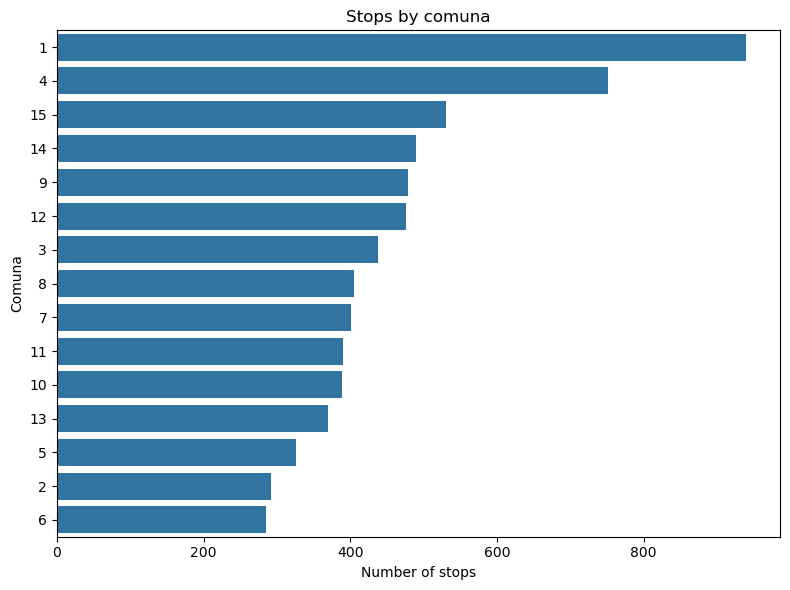

In [341]:
comuna_plot = comunas.copy().sort_values(by="n_stops", ascending=False)
comuna_plot["comuna"] = comuna_plot["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(ax=ax, data=comuna_plot, x="n_stops", y="comuna")
plt.title("Stops by comuna")
plt.xlabel("Number of stops")
plt.ylabel("Comuna")
plt.tight_layout()


Finally, I map the counts to see the spatial pattern and confirm it matches what I expect visually.

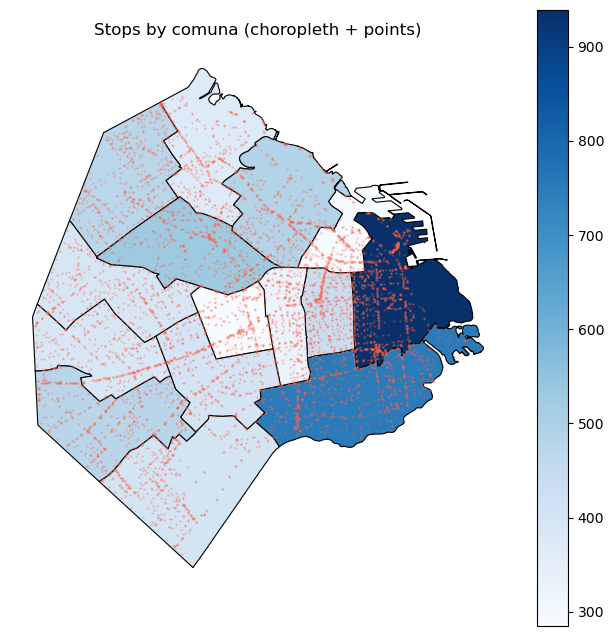

In [342]:
fig, ax = plt.subplots(figsize=(8, 8))

comunas.plot(ax=ax, column="n_stops", cmap="Blues", figsize=(6, 6), edgecolor="black", linewidth=0.8, legend=True)
stops.plot(ax=ax, markersize=0.5, color="tomato", alpha=0.3)
ax.set_title("Stops by comuna (choropleth + points)")
ax.set_axis_off()

Comuna 1 has the highest number of stops in this dataset. This is expected, since it covers a central area with high activity and many transit connections.

On the other hand, the comunas with the lowest stop counts may reflect lower stop density and/or more spread-out land use. I will confirm this later by looking at stops per km² (because raw counts can be misleading if the area is larger).

To add some context, I list the barrios included in the highest and lowest comunas (based on the official comunas layer).

In [343]:
top_comuna = comunas.loc[comunas["n_stops"].idxmax()]
bottom_comuna = comunas.loc[comunas["n_stops"].idxmin()]

display(top_comuna[["comuna", "barrios", "n_stops"]])
display(bottom_comuna[["comuna", "barrios", "n_stops"]])

comuna                                                     1
barrios    CONSTITUCION SAN TELMO MONSERRAT RETIRO PUERTO...
n_stops                                                  939
Name: 0, dtype: object

comuna             6
barrios    CABALLITO
n_stops          285
Name: 5, dtype: object

### 3.3 Stops by barrio

Here I count stops by barrio to see how stops are distributed at a finer spatial level than comunas.
I list the top and bottom barrios first, and then plot the top ones to make the comparison easier to read.

In [344]:
stops_by_barrio = stops.groupby("barrio").size().rename("n_stops").reset_index()
barrios = barrios.merge(stops_by_barrio,left_on="nombre",right_on="barrio",how="left")
barrios["n_stops"] = barrios["n_stops"].fillna(0)
barrios = barrios.drop(columns="barrio")

display(barrios.sort_values(by="n_stops", ascending=False)[["nombre", "n_stops"]].head(10))

display(barrios.sort_values(by="n_stops", ascending=False)[["nombre", "n_stops"]].tail(10))

,nombre,n_stops
20,PALERMO,488
2,BALVANERA,328
27,RECOLETA,300
39,VILLA LUGANO,293
7,CABALLITO,286
12,FLORES,280
3,BARRACAS,269
28,RETIRO,258
11,CONSTITUCION,221
4,BELGRANO,219


,nombre,n_stops
45,VILLA SANTA RITA,61
38,VILLA GRAL MITRE,59
25,PATERNAL,49
44,VILLA RIACHUELO,47
43,VILLA REAL,44
9,COGHLAN,41
0,AGRONOMIA,40
23,PARQUE CHAS,40
34,VERSALLES,34
26,PUERTO MADERO,22


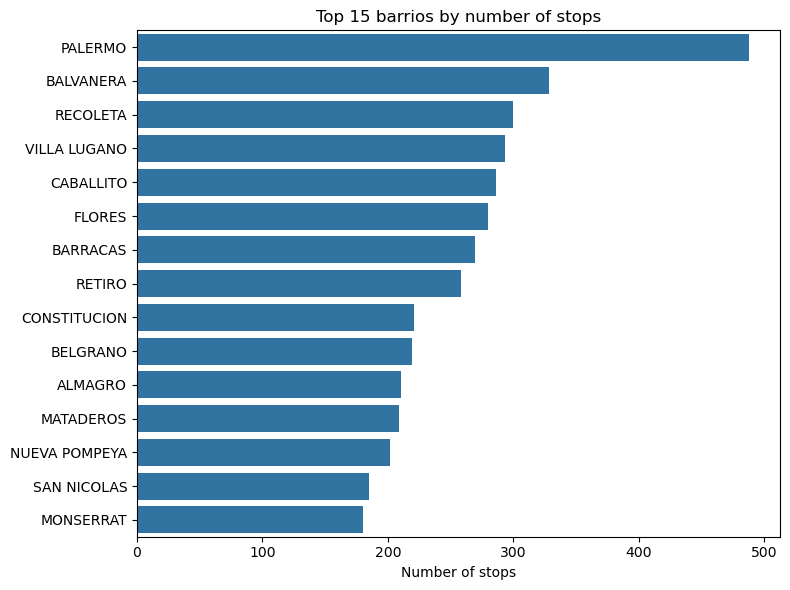

In [345]:
top_n = 15
barrios_plot = barrios.sort_values(by="n_stops", ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(data=barrios_plot, y="nombre", x="n_stops")
plt.title(f"Top {top_n} barrios by number of stops")
plt.xlabel("Number of stops")
plt.ylabel("")
plt.tight_layout()


Next, I map the stop counts by barrio. This adds spatial context and helps confirm whether the highest counts are concentrated in specific parts of the city.

I join the stop counts to the barrios layer so I can plot them as a choropleth.

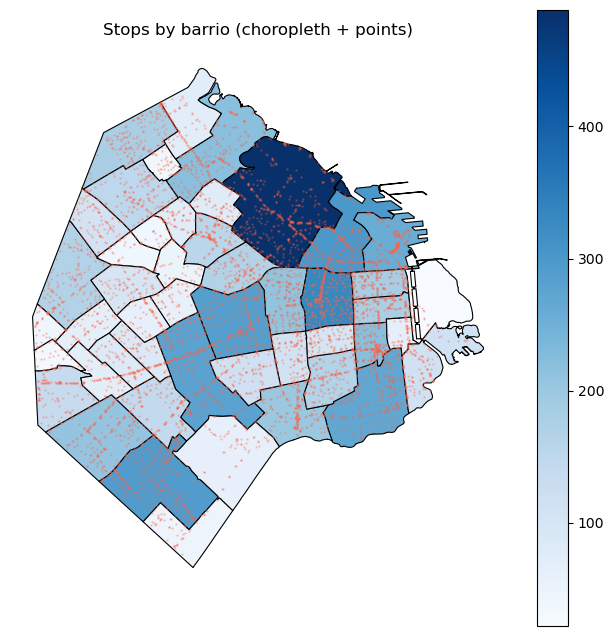

In [346]:
fig, ax = plt.subplots(figsize=(8,8))

barrios.plot(ax=ax, column="n_stops", cmap="Blues", figsize=(6, 6), edgecolor="black", linewidth=0.8, legend=True)
stops.plot(ax=ax, markersize=0.5, color="tomato", alpha=0.3)
ax.set_title("Stops by barrio (choropleth + points)")
ax.set_axis_off()

At this stage I only look at raw counts. In the next section I normalize by area (stops per km²), because larger barrios can naturally have more stops.

### 3.4 Density map (hexbin)

For an initial overview, bus stops were reprojected to UTM Zone 21S (EPSG:32721), which provides coordinates in meters and is well suited for local-scale spatial analysis in Buenos Aires.

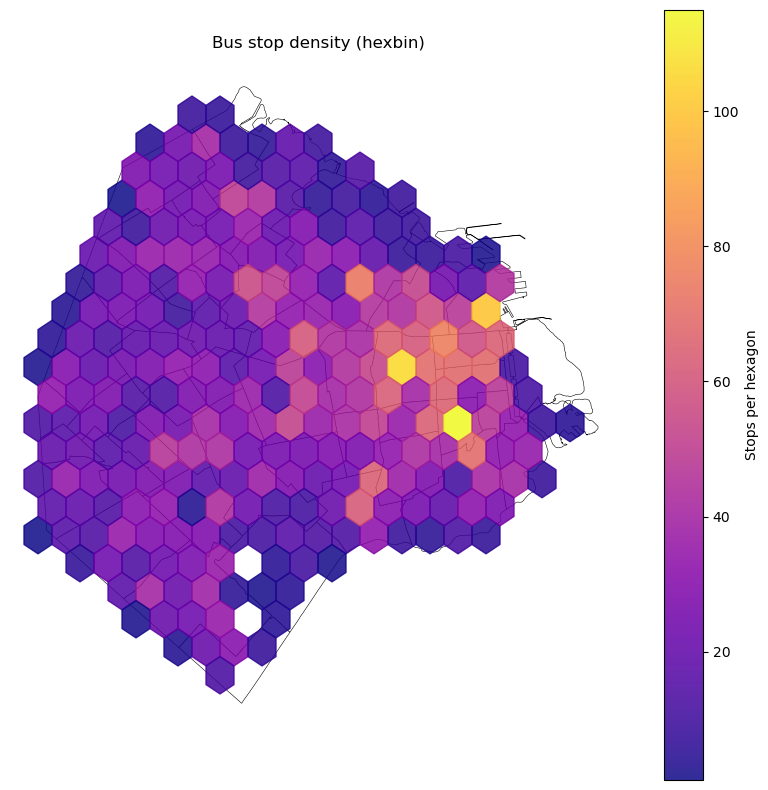

In [347]:
crs_m = "EPSG:32721"

stops_m = stops.to_crs(crs_m)
barrios_m = barrios.to_crs(crs_m)

x = stops_m.geometry.x
y = stops_m.geometry.y

fig, ax = plt.subplots(figsize=(8, 8))

# base
barrios_m.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=0.4)

# stable extent (bbox from CABA)
minx, miny, maxx, maxy = barrios_m.total_bounds

hb = ax.hexbin(x,y,gridsize=20,extent=(minx, maxx, miny, maxy),mincnt=1,cmap="plasma",alpha=0.85)

fig.colorbar(hb, ax=ax, label="Stops per hexagon")
ax.set_title("Bus stop density (hexbin)")
ax.set_axis_off()
plt.tight_layout()


The resulting hexbin map offers a high-level view of bus stop density across CABA, good for an exploratory overview.

## 4. Stops density

Both the comunas and barrios layers already include an official **area** field (in m²).
The official `area` field is provided in square meters (m²). I convert it to square kilometers (km²) by dividing by 1,000,000, since 1 km² = 1,000,000 m².

In [348]:
comunas["area_km2"] = comunas["area"] / 1000000
barrios["area_km2"] = barrios["area"] / 1000000

### 4.1 Area (km²) by comuna and barrio

Here I print a few summary statistics (min/median/mean/max) for the area of comunas and barrios. This gives me a quick sense of how different these administrative units are in size.

In [349]:
print("Comunas area_km2 (min/median/mean/max):",
      comunas["area_km2"].min(),
      comunas["area_km2"].median(),
      comunas["area_km2"].mean(),
      comunas["area_km2"].max())

print("Barrios area_km2 (min/median/mean/max):",
      barrios["area_km2"].min(),
      barrios["area_km2"].median(),
      barrios["area_km2"].mean(),
      barrios["area_km2"].max())

Comunas area_km2 (min/median/mean/max): 6.38599208 14.32289813 13.628204316 22.23309659
Barrios area_km2 (min/median/mean/max): 1.2322702700000001 3.679709125 4.249879914583333 15.92258617


As a quick check, I will look at the largest and smallest comunas/barrios by area, since raw stop counts can be influenced by how big the area is.

In [350]:
display(comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False).head(5))
display(comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False).tail(5))

display(barrios[["nombre", "area_km2"]].sort_values("area_km2", ascending=False).head(10))
display(barrios[["nombre", "area_km2"]].sort_values("area_km2", ascending=False).tail(10))


,comuna,area_km2
7,8,22.233097
3,4,21.690647
0,1,17.801036
8,9,16.505307
13,14,15.922564


,comuna,area_km2
6,7,12.422902
5,6,6.851030
4,5,6.660604
1,2,6.433392
2,3,6.385992


,nombre,area_km2
20,PALERMO,15.922586
39,VILLA LUGANO,9.296143
46,VILLA SOLDATI,8.690726
12,FLORES,8.590785
4,BELGRANO,8.060009
3,BARRACAS,7.955145
15,MATADEROS,7.398180
7,CABALLITO,6.851030
27,RECOLETA,6.433406
37,VILLA DEVOTO,6.404446


,nombre,area_km2
45,VILLA SANTA RITA,2.153691
0,AGRONOMIA,2.122170
11,CONSTITUCION,2.101995
30,SAN CRISTOBAL,2.043711
41,VILLA ORTUZAR,1.853802
34,VERSALLES,1.406834
23,PARQUE CHAS,1.385412
43,VILLA REAL,1.334146
9,COGHLAN,1.279951
32,SAN TELMO,1.232270


This plot shows the official area of each comuna. I include it as context, since comunas with larger area can naturally have more stops in raw counts, which is why I later focus on stops per km².

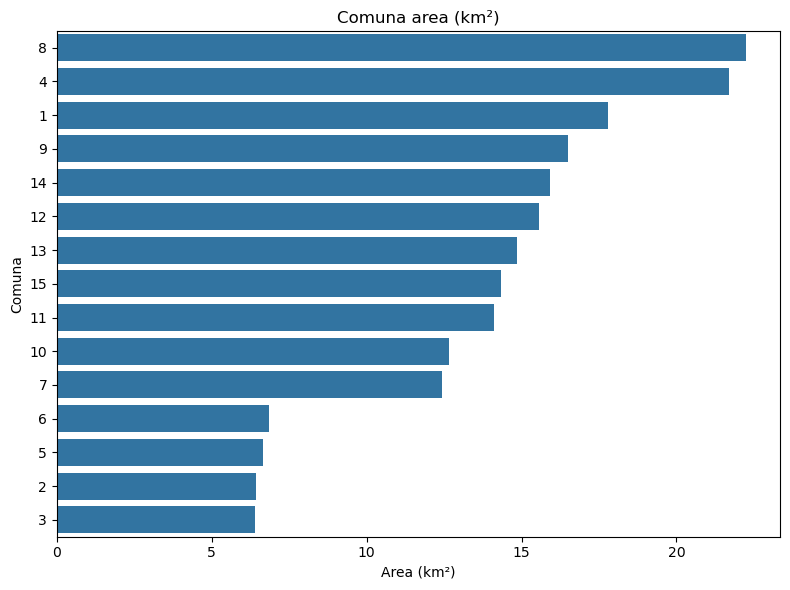

In [351]:
df_area = comunas[["comuna", "area_km2"]].sort_values("area_km2", ascending=False)
df_area["comuna"] = df_area["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=df_area, y="comuna", x="area_km2")
plt.title("Comuna area (km²)")
plt.xlabel("Area (km²)")
plt.ylabel("Comuna")
plt.tight_layout()

### 4.2 Stops density (stops per km²) by comuna and barrio

As a baseline, I first compute the overall stop density in CABA (total stops divided by total area). Then I break it down by comuna and barrio.

In [352]:
total_stops = stops.shape[0]
caba_area = comunas["area_km2"].sum()
stops_per_km2_caba = total_stops / caba_area

print(f"Overall stop density in CABA: {stops_per_km2_caba:.2f} stops per km²")

Overall stop density in CABA: 34.05 stops per km²


#### 4.2.1 Stops density by comuna

In [353]:
comunas["stops_per_km2"] = comunas["n_stops"] / comunas["area_km2"]
comunas[["comuna","area_km2","n_stops","stops_per_km2"]].sort_values("stops_per_km2", ascending=False)

,comuna,area_km2,n_stops,stops_per_km2
2,3,6.385992,438,68.587620
0,1,17.801036,939,52.749738
4,5,6.660604,326,48.944512
1,2,6.433392,292,45.388189
5,6,6.851030,285,41.599587
14,15,14.322898,531,37.073503
3,4,21.690647,752,34.669321
6,7,12.422902,401,32.279092
9,10,12.656558,389,30.735054
13,14,15.922564,489,30.711135


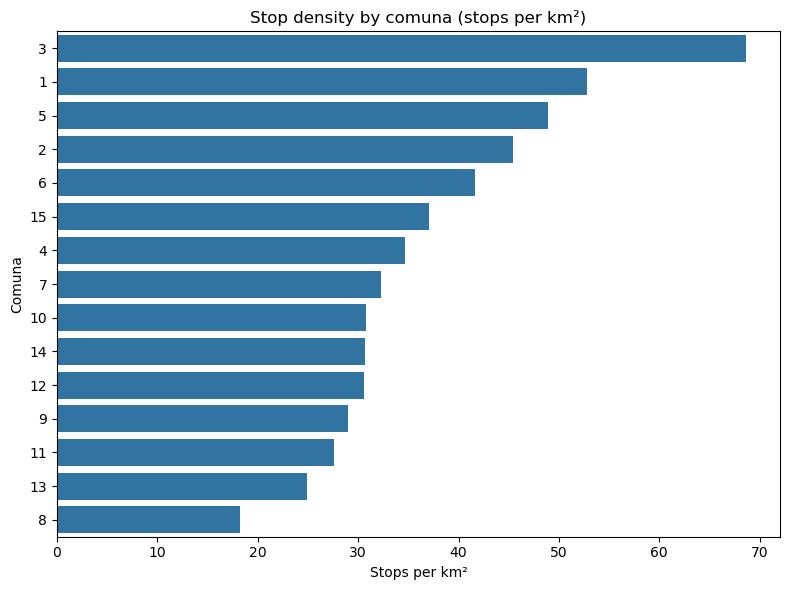

In [354]:
comunas_plot = comunas.copy().sort_values(by="stops_per_km2", ascending=False)
comunas_plot["comuna"] = comunas_plot["comuna"].astype(str)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(ax=ax, data=comunas_plot, y="comuna", x="stops_per_km2")
plt.title("Stop density by comuna (stops per km²)")
plt.xlabel("Stops per km²")
plt.ylabel("Comuna")
plt.tight_layout()


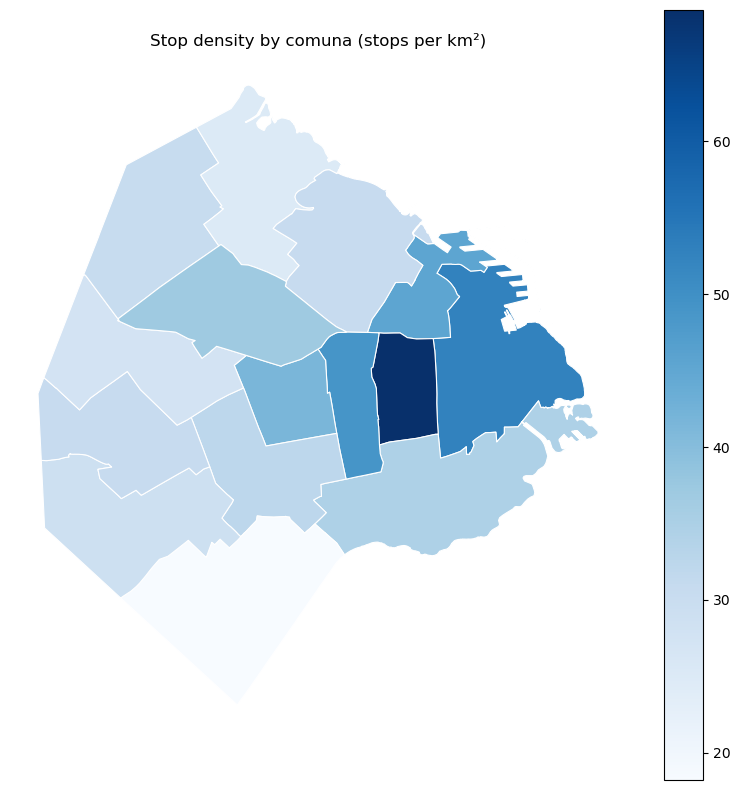

In [365]:
fig, ax = plt.subplots(figsize=(8, 8))

comunas.plot(ax=ax,column="stops_per_km2",cmap="Blues",edgecolor="white",linewidth=0.8,legend=True)
ax.set_title("Stop density by comuna (stops per km²)")
ax.set_axis_off()
plt.tight_layout()

#### 4.2.2 Stops density by barrio

In [361]:
barrios["stops_per_km2"] = barrios["n_stops"] / barrios["area_km2"]
(
    barrios[["nombre","area_km2","n_stops","stops_per_km2"]]
    .sort_values(by="stops_per_km2",ascending=False)
    .head(10)
)

,nombre,area_km2,n_stops,stops_per_km2
11,CONSTITUCION,2.101995,221,105.138204
16,MONSERRAT,2.198622,180,81.869456
31,SAN NICOLAS,2.289008,185,80.821044
2,BALVANERA,4.342281,328,75.536342
28,RETIRO,4.514378,258,57.150734
32,SAN TELMO,1.232270,66,53.559679
1,ALMAGRO,4.050753,210,51.842218
30,SAN CRISTOBAL,2.043711,103,50.398508
8,CHACARITA,3.115707,156,50.068886
35,VILLA CRESPO,3.615978,169,46.737011


In [362]:
(
    barrios[["nombre","area_km2","n_stops","stops_per_km2"]]
    .sort_values(by="stops_per_km2",ascending=False)
    .tail(10)
)

,nombre,area_km2,n_stops,stops_per_km2
37,VILLA DEVOTO,6.404446,169,26.387919
17,MONTE CASTRO,2.627482,64,24.357925
34,VERSALLES,1.406834,34,24.167746
5,LA BOCA,5.037482,118,23.424401
25,PATERNAL,2.229829,49,21.974777
0,AGRONOMIA,2.122170,40,18.848635
19,NUÑEZ,4.496656,74,16.456672
44,VILLA RIACHUELO,4.239850,47,11.085298
46,VILLA SOLDATI,8.690726,61,7.018976
26,PUERTO MADERO,5.043241,22,4.362274


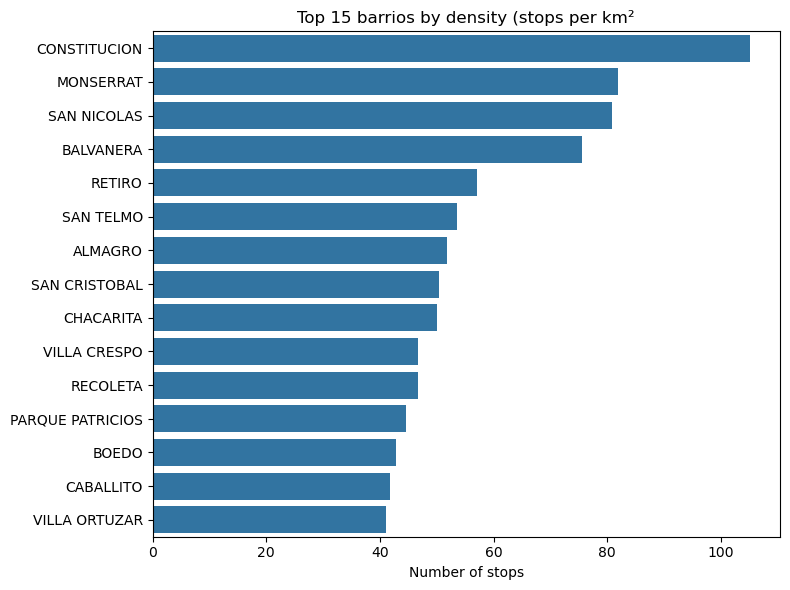

In [364]:
top_n = 15
barrios_plot = barrios.copy().sort_values(by="stops_per_km2",ascending=False).head(top_n)
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(ax=ax, data=barrios_plot, x="stops_per_km2", y="nombre")
plt.title(f"Top {top_n} barrios by density (stops per km²")
plt.xlabel("Number of stops")
plt.ylabel("")
plt.tight_layout()


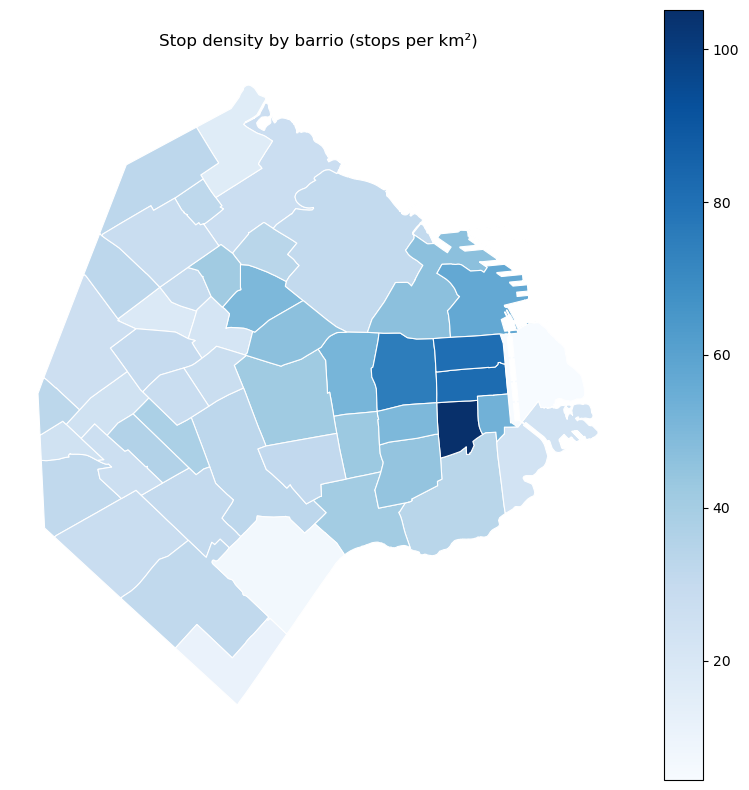

In [366]:
fig, ax = plt.subplots(figsize=(8, 8))

barrios.plot(ax=ax,column="stops_per_km2",cmap="Blues",edgecolor="white",linewidth=0.8,legend=True)
ax.set_title("Stop density by barrio (stops per km²)")
ax.set_axis_off()
plt.tight_layout()

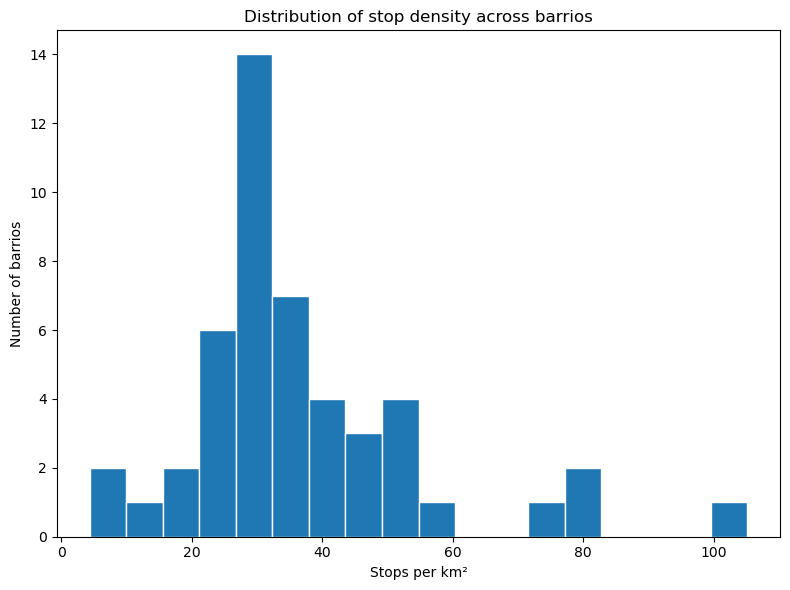

In [367]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(barrios["stops_per_km2"], bins=18, edgecolor="white")
plt.title("Distribution of stop density across barrios")
plt.xlabel("Stops per km²")
plt.ylabel("Number of barrios")
plt.tight_layout()
